# Multiclass classification - single_model using Naive Bayes-TFIDF(semeval)

# Importing and Preprocessing

## Importing libraries

In [1]:
#### import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from textblob import Word
from textblob import TextBlob

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn.decomposition import PCA
from sklearn.datasets import load_iris
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

from modAL.models import ActiveLearner
from modAL.models import ActiveLearner

import en_core_web_sm
nlp = en_core_web_sm.load()

%matplotlib inline

## Importing files

In [2]:
original_data = pd.read_csv('../../)
original_data = original_data.drop(labels='Unnamed: 0', axis=1)
original_data = original_data.rename(columns={'reference_answer':'ref_answer'})

FileNotFoundError: File b'../dataset/Semeval_dataset/train_semeval.csv' does not exist

## Preprocessing

In [3]:
df = original_data.copy()
#converting to lower case
df['ref_modified'] = df['ref_answer'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df['student_modified'] = df['student_answer'].apply(lambda x: " ".join(x.lower() for x in x.split()))

#punctuation removal
df['ref_modified'] = df['ref_modified'].str.replace('[^\w\s]','')
df['student_modified'] = df['student_modified'].str.replace('[^\w\s]','')

#stop word removal
stop = stopwords.words('english')
df['ref_modified'] = df['ref_modified'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df['student_modified'] = df['student_modified'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))


#lemmatisation
df['ref_modified'] = df['ref_modified'].apply(lambda x: " ".join([Word(word).lemmatize() for word in word_tokenize(x)]))
df['student_modified'] = df['student_modified'].apply(lambda x: " ".join([Word(word).lemmatize() for word in word_tokenize(x)]))

# Gathering required features

In [4]:
short_df = df[['question','student_answer','student_modified','ref_modified' ,'grade']]
short_df['status'] = short_df['grade']
short_df['status'].unique()

/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


array([2, 5, 4, 0, 3])

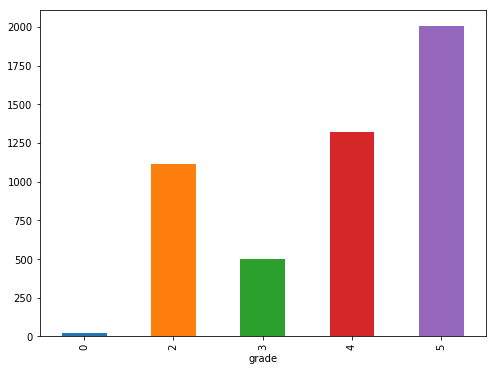

In [5]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('grade').student_modified.count().plot.bar(ylim=0)
plt.show()

# Tfidf

In [7]:
# short_df['word_count'] = short_df['student_answer'].apply(lambda x: dict(Counter(x.split())))

# counting unique words in every student's answer
Tf = TfidfVectorizer()
student_answer_count_vector = Tf.fit_transform(short_df['student_modified'])
student_answer_count_vector = student_answer_count_vector.toarray()

X = student_answer_count_vector
Y = short_df['status'].values

# Seeding

In [8]:
#getting the seed index
classes = short_df['status'].unique()
seed_index = []
for i in classes:
    seed_index.append(short_df['status'][short_df['status']==i].index[0])
seed_index

[0, 1, 16, 30, 79]

In [9]:
act_data = short_df.copy()
accuracy_list = []

# initialising
train_idx = seed_index
X_train = X[train_idx]
y_train = Y[train_idx]
 
# generating the pool
X_pool = np.delete(X, train_idx, axis=0)
y_pool = np.delete(Y, train_idx)

act_data = act_data.drop(axis=0,index = train_idx)
act_data.reset_index(drop = True,inplace=True)


# initializing the active learner
# lr = LogisticRegression()
nb = MultinomialNB()
learner = ActiveLearner(
#     estimator = lr,
    estimator = nb,
#     estimator = RandomForestClassifier(n_estimators=5),
#     estimator=KNeighborsClassifier(n_neighbors=3),
    X_training=X_train, y_training=y_train
)

# pool-based sampling
n_queries = int(len(X)/5)
for idx in range(n_queries):
    query_idx, query_instance = learner.query(X_pool)
#     print("\nQ: ", act_data.loc[int(query_idx),'question'])
#     print("A: ",act_data.loc[int(query_idx),'student_answer'])
#     print("Actual grade: ",y_pool[query_idx].reshape(1, ))
#     print ("Class probabilities: ",learner.predict_proba(X_pool[query_idx].reshape(1, -1)))
#     human_label = int(input("\nGive me a grade 0 or 1:"))
    
    learner.teach(
        X=X_pool[query_idx].reshape(1, -1),
        y=y_pool[query_idx].reshape(1, )
    )
    
    # remove queried instance from pool
    X_pool = np.delete(X_pool, query_idx, axis=0)
    y_pool = np.delete(y_pool, query_idx)
    
    act_data = act_data.drop(axis=0,index = query_idx)
    act_data.reset_index(drop=True, inplace=True)
    
    accuracy_list.append(learner.score(X_pool,y_pool))
    print('Accuracy after query no. %d: %f' % (idx+1, learner.score(X_pool, y_pool)))
print("======================================")
print("By just labelling ",round(n_queries*100.0/len(X),2),"% of total data accuracy of ", round(learner.score(X_pool, y_pool),3), " % is achieved on the unseen data"  )

Accuracy after query no. 1: 0.267177
Accuracy after query no. 2: 0.042523
Accuracy after query no. 3: 0.051602
Accuracy after query no. 4: 0.262298
Accuracy after query no. 5: 0.262351
Accuracy after query no. 6: 0.238806
Accuracy after query no. 7: 0.238047
Accuracy after query no. 8: 0.264326
Accuracy after query no. 9: 0.265187
Accuracy after query no. 10: 0.265644
Accuracy after query no. 11: 0.275389
Accuracy after query no. 12: 0.307754
Accuracy after query no. 13: 0.307817
Accuracy after query no. 14: 0.308081
Accuracy after query no. 15: 0.307537
Accuracy after query no. 16: 0.281730
Accuracy after query no. 17: 0.308874
Accuracy after query no. 18: 0.290740
Accuracy after query no. 19: 0.280081
Accuracy after query no. 20: 0.280542
Accuracy after query no. 21: 0.291726
Accuracy after query no. 22: 0.282072
Accuracy after query no. 23: 0.277677
Accuracy after query no. 24: 0.284211
Accuracy after query no. 25: 0.284268
Accuracy after query no. 26: 0.283313
Accuracy after query 

Accuracy after query no. 216: 0.379528
Accuracy after query no. 217: 0.379608
Accuracy after query no. 218: 0.389802
Accuracy after query no. 219: 0.388620
Accuracy after query no. 220: 0.388912
Accuracy after query no. 221: 0.386886
Accuracy after query no. 222: 0.386335
Accuracy after query no. 223: 0.383042
Accuracy after query no. 224: 0.386076
Accuracy after query no. 225: 0.389956
Accuracy after query no. 226: 0.394470
Accuracy after query no. 227: 0.393498
Accuracy after query no. 228: 0.391892
Accuracy after query no. 229: 0.390496
Accuracy after query no. 230: 0.390579
Accuracy after query no. 231: 0.390661
Accuracy after query no. 232: 0.394759
Accuracy after query no. 233: 0.396111
Accuracy after query no. 234: 0.395137
Accuracy after query no. 235: 0.394587
Accuracy after query no. 236: 0.394459
Accuracy after query no. 237: 0.395388
Accuracy after query no. 238: 0.392510
Accuracy after query no. 239: 0.392593
Accuracy after query no. 240: 0.389712
Accuracy after query no. 

Accuracy after query no. 428: 0.438051
Accuracy after query no. 429: 0.440573
Accuracy after query no. 430: 0.439568
Accuracy after query no. 431: 0.436797
Accuracy after query no. 432: 0.436011
Accuracy after query no. 433: 0.433900
Accuracy after query no. 434: 0.438190
Accuracy after query no. 435: 0.437845
Accuracy after query no. 436: 0.439046
Accuracy after query no. 437: 0.438259
Accuracy after query no. 438: 0.438135
Accuracy after query no. 439: 0.439558
Accuracy after query no. 440: 0.438992
Accuracy after query no. 441: 0.439531
Accuracy after query no. 442: 0.437859
Accuracy after query no. 443: 0.437293
Accuracy after query no. 444: 0.437168
Accuracy after query no. 445: 0.436380
Accuracy after query no. 446: 0.438026
Accuracy after query no. 447: 0.437016
Accuracy after query no. 448: 0.435784
Accuracy after query no. 449: 0.436102
Accuracy after query no. 450: 0.434869
Accuracy after query no. 451: 0.434079
Accuracy after query no. 452: 0.433511
Accuracy after query no. 

Accuracy after query no. 640: 0.458372
Accuracy after query no. 641: 0.459635
Accuracy after query no. 642: 0.459047
Accuracy after query no. 643: 0.458922
Accuracy after query no. 644: 0.459259
Accuracy after query no. 645: 0.459366
Accuracy after query no. 646: 0.458546
Accuracy after query no. 647: 0.458420
Accuracy after query no. 648: 0.455746
Accuracy after query no. 649: 0.455852
Accuracy after query no. 650: 0.457348
Accuracy after query no. 651: 0.457222
Accuracy after query no. 652: 0.456169
Accuracy after query no. 653: 0.456507
Accuracy after query no. 654: 0.460325
Accuracy after query no. 655: 0.460432
Accuracy after query no. 656: 0.457521
Accuracy after query no. 657: 0.454144
Accuracy after query no. 658: 0.458198
Accuracy after query no. 659: 0.458304
Accuracy after query no. 660: 0.457714
Accuracy after query no. 661: 0.458285
Accuracy after query no. 662: 0.458391
Accuracy after query no. 663: 0.459196
Accuracy after query no. 664: 0.459302
Accuracy after query no. 

Accuracy after query no. 853: 0.486500
Accuracy after query no. 854: 0.484428
Accuracy after query no. 855: 0.485276
Accuracy after query no. 856: 0.487585
Accuracy after query no. 857: 0.485513
Accuracy after query no. 858: 0.484170
Accuracy after query no. 859: 0.484287
Accuracy after query no. 860: 0.485380
Accuracy after query no. 861: 0.485498
Accuracy after query no. 862: 0.485129
Accuracy after query no. 863: 0.484516
Accuracy after query no. 864: 0.486829
Accuracy after query no. 865: 0.485728
Accuracy after query no. 866: 0.486091
Accuracy after query no. 867: 0.486942
Accuracy after query no. 868: 0.487549
Accuracy after query no. 869: 0.487912
Accuracy after query no. 870: 0.488031
Accuracy after query no. 871: 0.487662
Accuracy after query no. 872: 0.487781
Accuracy after query no. 873: 0.488634
Accuracy after query no. 874: 0.488264
Accuracy after query no. 875: 0.488873
Accuracy after query no. 876: 0.488014
Accuracy after query no. 877: 0.489356
Accuracy after query no. 

## Regular supervised task

## Importing test data

In [11]:
original_data = pd.read_csv('../dataset/Semeval_dataset/test1_semeval.csv')
original_data = original_data.drop(labels='Unnamed: 0', axis=1)
original_data = original_data.rename(columns={'reference_answer':'ref_answer'})
df = original_data.copy()
#converting to lower case
df['ref_modified'] = df['ref_answer'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df['student_modified'] = df['student_answer'].apply(lambda x: " ".join(x.lower() for x in x.split()))

#punctuation removal
df['ref_modified'] = df['ref_modified'].str.replace('[^\w\s]','')
df['student_modified'] = df['student_modified'].str.replace('[^\w\s]','')

#stop word removal
stop = stopwords.words('english')
df['ref_modified'] = df['ref_modified'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df['student_modified'] = df['student_modified'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))


#lemmatisation
df['ref_modified'] = df['ref_modified'].apply(lambda x: " ".join([Word(word).lemmatize() for word in word_tokenize(x)]))
df['student_modified'] = df['student_modified'].apply(lambda x: " ".join([Word(word).lemmatize() for word in word_tokenize(x)]))
short_df = df[['question','student_answer','student_modified','ref_modified' ,'grade']]
short_df['status'] = short_df['grade'] 

# counting unique words in every student's answer
student_answer_count_vector = Tf.transform(short_df['student_modified'])
student_answer_count_vector = student_answer_count_vector.toarray()

X_test = student_answer_count_vector
Y_test = short_df['status'].values 
# Y_test = np.reshape(Y_test, (-1, 1))
X_train = np.copy(X)
Y_train = np.copy(Y)
X_test.shape

/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(540, 1908)

In [12]:
# logisticRegr = LogisticRegression()
naive_bayes = MultinomialNB()
naive_bayes.fit(X_train, Y_train)
score = naive_bayes.score(X_test, Y_test)

print(score)

0.4759259259259259


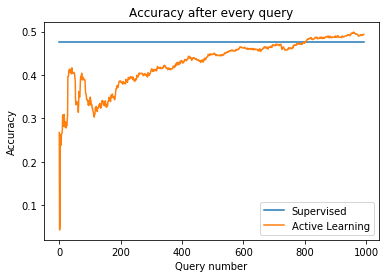

In [13]:
supervised_accuracy = [score for x in range(0,n_queries)]

plt.figure()
plt.plot(np.linspace(0,n_queries-1,n_queries),supervised_accuracy)
plt.plot(accuracy_list)
plt.title("Accuracy after every query")
plt.xlabel("Query number")
plt.ylabel("Accuracy")
plt.legend(["Supervised", "Active Learning"], loc="lower right")
plt.show()

In [14]:
score = learner.score(X_test, Y_test)
score

0.4203703703703704

In [15]:
y_pred_ai = learner.predict(X_test)
y_pred_sup = naive_bayes.predict(X_test)

In [16]:
from sklearn.metrics import f1_score

f1_score(Y_test, y_pred_ai,average='weighted')  


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.4058503131440985

In [17]:
f1_score(Y_test, y_pred_sup,average='weighted')  


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.433492609374561